# Tutorial 3 : Neural Processes - 1D GP Data

Last Update : 11 June 2019

**Aim**: 
- Training a simple [Attentive Neural Process] (ANP)
- See how well a ANP "learns" a GP kernel

**Nota Bene:**
- Much more details about the framework and dataset can be found in [Tutorial 1 - Conditional Neural Process].
- Not much hyperparameter optimization done
- Architecture differs slightly from the paper to be more general and modularizable for future work.

[Attentive Neural Process]: https://arxiv.org/abs/1901.05761
[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

**Environment Hypermarameters:**

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Environment

In [2]:
cd ..

/master


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""

import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset

In this notebook I only look at the periodic and mattern kernel. See [Tutorial 1 - Conditional Neural Process] for more details.

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [4]:
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, DotProduct, ConstantKernel
from ntbks_viz import plot_posterior_samples, plot_prior_samples, plot_dataset_samples

from ntbks_datasets import GPDataset

In [5]:
X_DIM = 1  # 1D spatial input
Y_DIM = 1  # 1D regression
N_POINTS = 128
N_SAMPLES = 100000 # this is a lot and can work with less

In [6]:
datasets = dict()
kwargs = dict(n_samples=N_SAMPLES, n_points=N_POINTS)
datasets["rbf"] = GPDataset(kernel=1.0 * RBF(length_scale=1.0,
                                             length_scale_bounds=(1e-1, 10.0)),
                            **kwargs)

datasets["periodic"] = GPDataset(kernel=1.0 * ExpSineSquared(length_scale=1.0,
                                                             periodicity=3.0,
                                                             length_scale_bounds=(0.1, 10.0),
                                                             periodicity_bounds=(1.0, 10.0)),
                                 **kwargs)
datasets["non-stationary"] = GPDataset(kernel=(ConstantKernel(0.1, (0.01, 10.0)) *
                                               (DotProduct(sigma_0=1.0,
                                                           sigma_0_bounds=(0.1, 10.0)) ** 2)),
                                       **kwargs)
datasets["matern"] = GPDataset(kernel=1.0 * Matern(length_scale=1.0,
                                                   length_scale_bounds=(1e-1, 10.0),
                                                   nu=1.5),
                               **kwargs)

Let's visualize some of the uncoditional samples from the dataset:

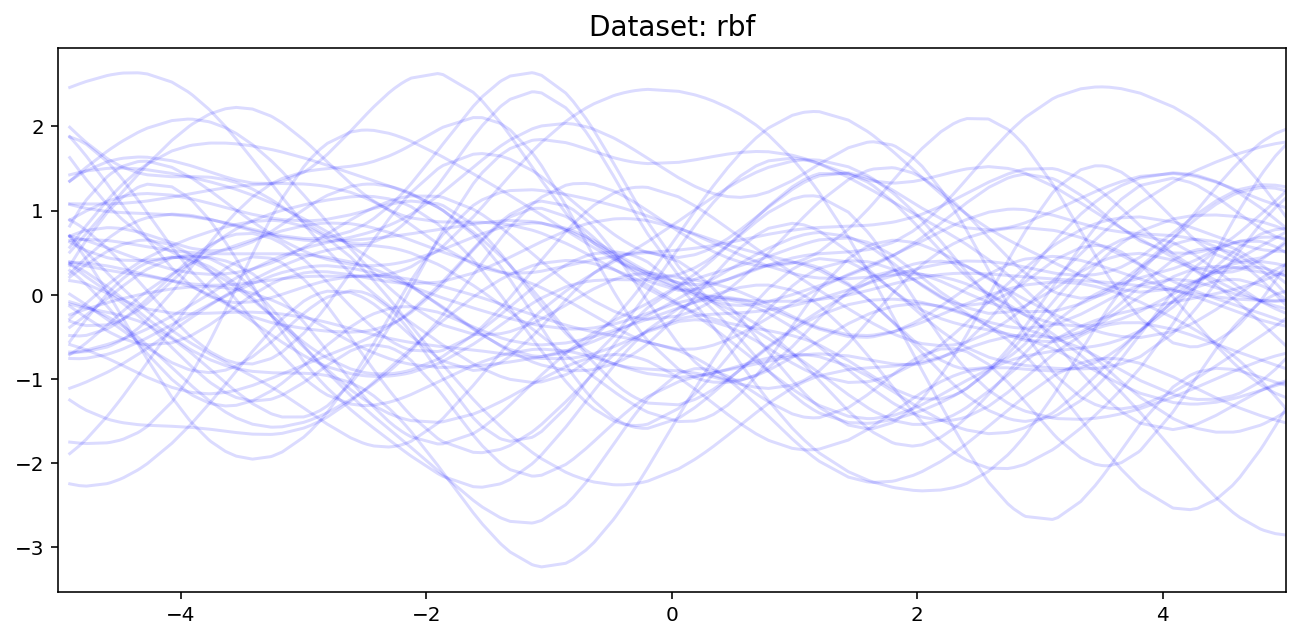

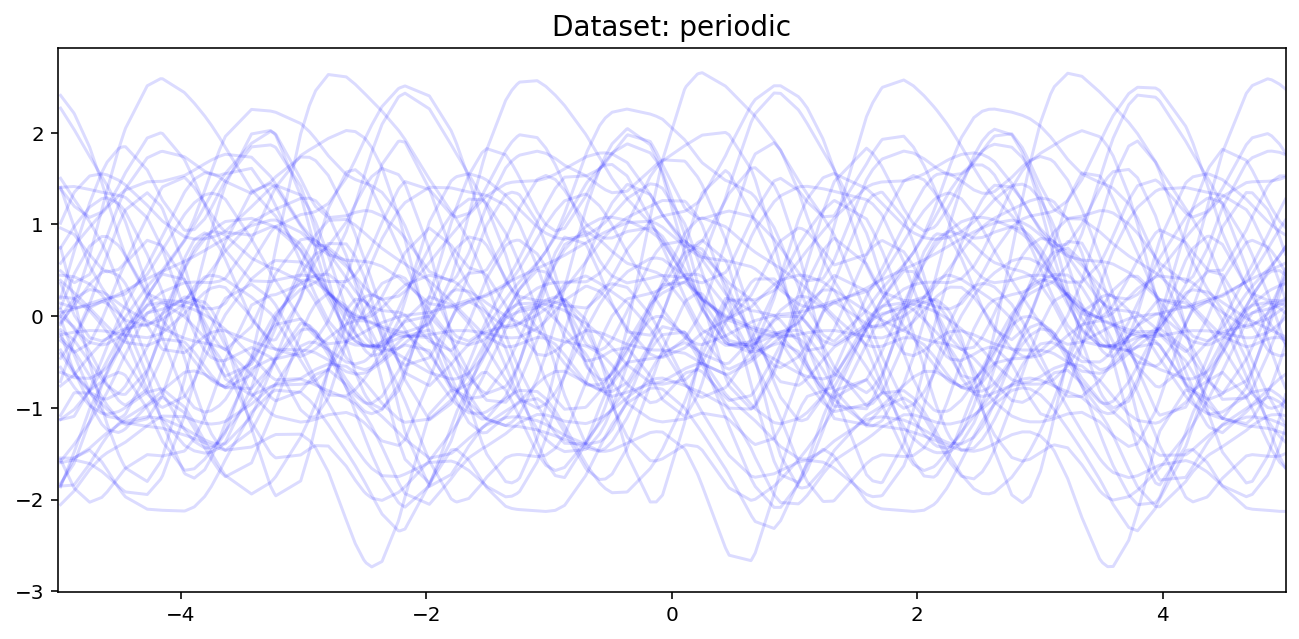

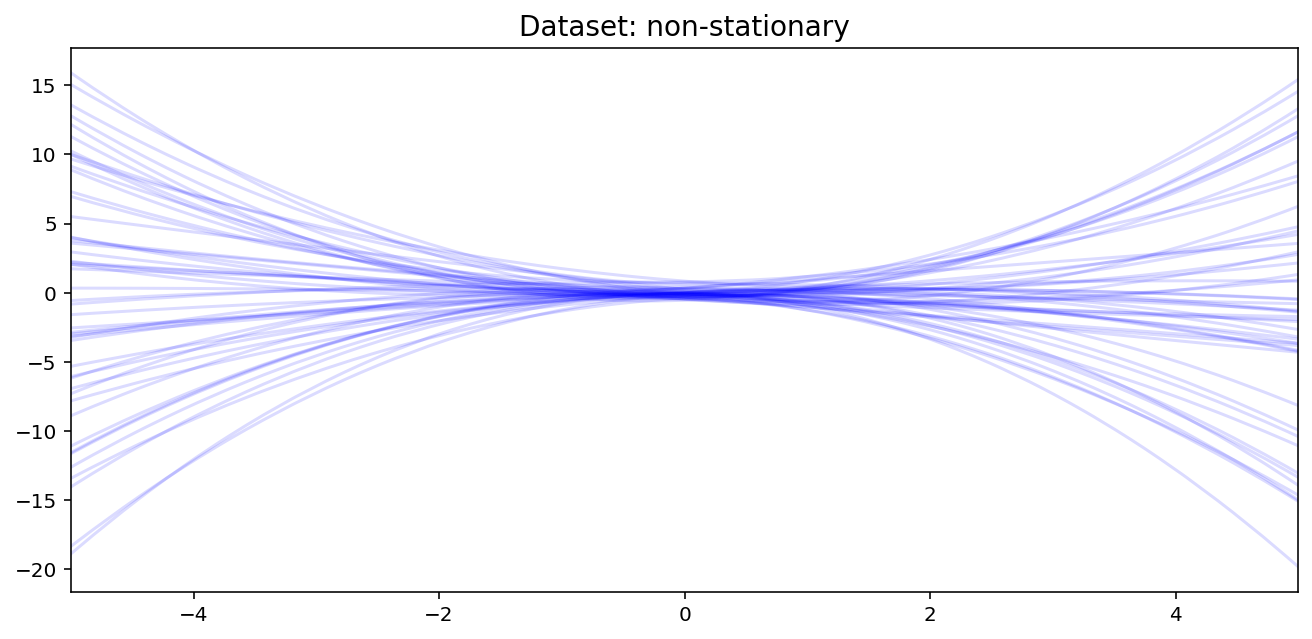

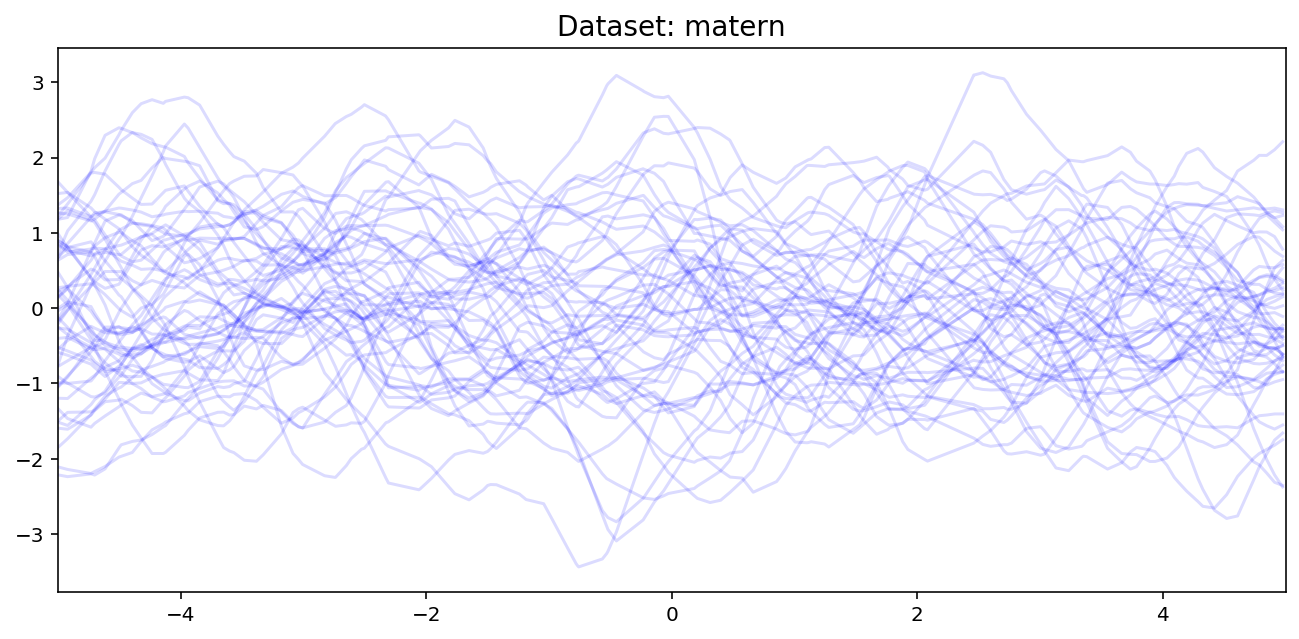

In [7]:
for k, dataset in datasets.items():
    plot_dataset_samples(dataset, title="Dataset: {}".format(k))

## Model

The general model architecture is slightly different from the paper to make it modular and easy to extend, but it is easy to make them equivalent with the right parameters. Refer to [Tutorial 1 - Conditional Neural Process] for an overview main parameters or the docstrings of `NeuralProcess` for all parameters. 

[Tutorial 1 - Conditional Neural Process]: Tutorial%201%20-%20Conditional%20Neural%20Process.ipynb

In [8]:
from torch.distributions import Normal

from skssl.transformers import (NeuralProcessLoss, NeuralProcess, AttentiveNeuralProcess, 
                                SelfAttentionBlock, SinusoidalEncodings)
from skssl.predefined import MLP, add_flat_input, DeepMLP
from skssl.transformers.neuralproc.datasplit import context_target_split

In [9]:
R_DIM = 128
RANGE_CNTXT = (4, 50)  # context points will be sampled uniformly in this range
RANGE_EXTRA_TRGTS = (3, N_POINTS-RANGE_CNTXT[1])  # extra number of targtes points 

In [10]:
def get_cntxt_trgt(*args):
    return context_target_split(*args, range_cntxts=RANGE_CNTXT, range_extra_trgts=RANGE_EXTRA_TRGTS)

def init_model():
    return AttentiveNeuralProcess(X_DIM, Y_DIM,
                                  XEncoder=MLP, # no sinusoidal encodings
                                  XYEncoder=add_flat_input(DeepMLP),  # no self attention encoder (3 hidden layer MLP)
                                  Decoder=add_flat_input(DeepMLP), # no self attention decoder (3 hidden layer MLP)
                                  r_dim=R_DIM,
                                  get_cntxt_trgt=get_cntxt_trgt,
                                  aggregator=torch.mean, # only used for latent path
                                  PredictiveDistribution=Normal, # Gaussian predictive distribution
                                  LatentEncoder=MLP,
                                  attention="scaledot", # parameter free attention because simple task
                                  encoded_path="both") # use both latent  and deterministic path as in paper

In [11]:
# initialize one model for each dataset
data_models = {name: (init_model(), data) 
               for name, data in datasets.items()}

/master/skssl/predefined/mlp.py:56: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


### N Param

Number of parameters (note that I did not play around with this much, this depends a lot on the representation size):

In [12]:
from utils.helpers import count_parameters

In [13]:
for k, (neural_proc, dataset) in data_models.items():
    print("N Param:", count_parameters(neural_proc))
    break

N Param: 219074


### Prior Samples
We can visualize the prior (i.e. the output of the neural process without any context points) before training.

std: 0.3210298490524293


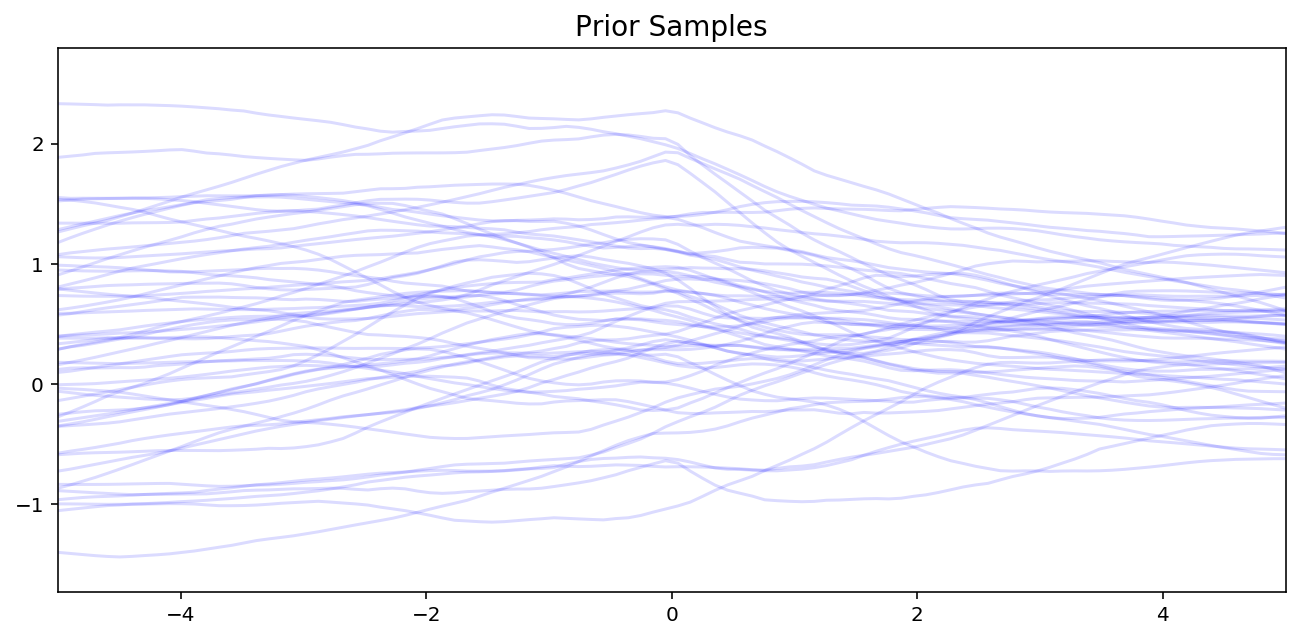

In [14]:
for k, (neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, train_min_max=dataset.min_max)
    # all the models at the start are "similar" so plot only one
    break

## Training

In [15]:
from skorch.callbacks import ProgressBar, Checkpoint

from skssl.training import NeuralNetTransformer
from skssl.training.helpers import make_Xy_input

In [16]:
N_EPOCHS = 50
# using a small batch size seems important, probably because
# use fix amount of context in batch, and with attention you 
# don't have aggregation => the number of context points
# changes the attention mechanism (the softmax) => use small
# to have many different (they use 16)
BATCH_SIZE = 16 
is_RETRAIN = True # if false load precomputed

In [ ]:
for k,(neural_proc, dataset) in data_models.items():
    print()
    print("--- {} {} ---".format("Training" if is_RETRAIN else "Loading", k))
    print()
    
    chckpt = Checkpoint(dirname="results/notebooks/neural_process/anp_dotattn_{}".format(k), 
                        monitor='train_loss_best') # train would be same as validation as always resamples
    
    model = NeuralNetTransformer(neural_proc, NeuralProcessLoss,
                                 max_epochs=N_EPOCHS,
                                 batch_size=BATCH_SIZE,
                                 train_split=None,  # don't use cross validation dev set
                                 lr=5e-4, # smaller lr because small batch size (they use 5e-5)
                                 callbacks=[ProgressBar(), 
                                            chckpt], # checkpoint best model
                                ) 
    
    if is_RETRAIN:
        _=model.fit(*make_Xy_input(dataset))
    
    # load in all case => even when training loads the best checkpoint
    model.initialize()
    model.load_params(checkpoint=chckpt)


--- Training rbf ---



  epoch    train_loss    cp       dur
-------  ------------  ----  --------
      1       89.0513     +  102.5766


      2       26.0918     +  97.9046


      3       -0.4968     +  109.1555


      4      -21.5810     +  104.6193


      5      -38.1636     +  110.2066


      6      -56.2726     +  110.2551


      7      -64.9212     +  99.2598


      8      -77.6145     +  100.6906


      9      -83.1977     +  104.2902


     10      -91.4350     +  110.9571


     11      -94.6531     +  94.7968


     12      -99.8994     +  100.4847


     13     -104.0676     +  103.6235


     14     -100.9246        106.5093


     15     -102.1352        109.1260


     16     -104.6680     +  102.8057


     17     -104.9116     +  82.4476


     18     -106.4166     +  100.8398


     19     -104.8085        109.1419


     20     -108.7923     +  99.3556


     21     -109.2126     +  104.5508


     22     -110.5493     +  105.5623


# Trained Prior

In [ ]:
EXTRAP_DISTANCE = 2  # add 2 to the right for extrapolation
INTERPOLATION_RANGE = dataset.min_max
EXTRAPOLATION_RANGE = (dataset.min_max[0], dataset.min_max[1]+EXTRAP_DISTANCE )

In [ ]:
for k,(neural_proc, dataset) in data_models.items():
    plot_prior_samples(neural_proc, 
                       title="Trained Prior Samples : {}".format(k), 
                       test_min_max=EXTRAPOLATION_RANGE, 
                       train_min_max=INTERPOLATION_RANGE)

# Posterior

In [ ]:
N_CNTXT = 10
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 2
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           n_samples=30,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))

In [ ]:
N_CNTXT = 20
for k,(neural_proc, dataset) in data_models.items():
    plot_posterior_samples(dataset, neural_proc, 
                           n_cntxt=N_CNTXT, 
                           test_min_max=EXTRAPOLATION_RANGE, 
                           n_points=2*N_POINTS,
                           title="Posterior Samples Conditioned on {} Context Points : {}".format(N_CNTXT, k))